## Temp

In [260]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
# Read the csv files and index appropriately.
ratings_small_df = pd.read_csv('./data/ratings_small.csv')
ratings_df = pd.read_csv('./data/ratings.csv')
links_small_df = pd.read_csv('./data/links_small.csv')
links_df = pd.read_csv('./data/links.csv')
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')
# Reading the movies_metadata.csv file throws a DtypeWarning.
# It's the popularity feature. I deleted it.

In [262]:
dataframes = (ratings_small_df, ratings_df, links_small_df, links_df, keywords_df, credits_df, metadata_df)
# Pandas DataFrames don't have name attributes.
df_names = ("ratings_small", "ratings", "links_small", "links", "keywords", "credits", "movies_metadata")

In [263]:
# Print the names of all the features in each file.
#for df, name in zip(dataframes, df_names):
#    print("\n" + "Dataframe: " + name + "\nNaN Values:")
#    print(df.isnull().sum())

In [264]:
# links_small has some NaN values. Print the unique values to see what we're expecting. 
print(links_small_df.tmdbId.unique())
# It's in the tmdbId column, which seem to be ID numbers for some movies.
# We probably won't use links in actual analysis, so I'm not going to worry about it.

[    862.    8844.   15602. ...,  391698.  137608.  410803.]


In [265]:
# Lots of NaNs in movie_metadata, just print out the first couple of entries to see what's going on.
metadata_df.head(2)
# belongs_to_collection seems fine, that's not simple data and is probably just Python being confused about what to expect.
# homepage throws NaN when there's not a homepage it seems. Probably want to do a one-hot replacement here.
# imdb_id is missing 17 IDs, we should probably just drop these movies.
# original_language: 11, just drop them.
# overview:
# popularity: 5, just drop them.
# poster_path:
# production (general): Just names of companies/countries. Just drop the 3 movies.
# release_date: should probably just drop the samples with missing values, I can't think of a way to fill in the values.
# revenue, spoken languages, title, video, votes all have 6 NaNs. I'd wager they're the same movies, we should drop the samples.
# runtime: We can probably just fill in with a mean/median.
# status: We should do some sort of hot-encoding here, then the NaNs will just be columns of 0. Will print uniques to check.
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence one-hot variable

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSE,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,FALSE,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [266]:
print(metadata_df.status.unique())
# 6 one-hot variables don't seem too bad. It's an option.

['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


In [267]:
#for df, name in zip(dataframes, df_names):
#    print("\n" + "Dataframe: " + name + "\n")
#    print(df.describe())

In [268]:
"""
for df, name in zip(dataframes, df_names):
    plt.figure()
    #print("\n" + "Dataframe: " + name + "\n")
    df.hist(figsize=(8,8))
"""

'\nfor df, name in zip(dataframes, df_names):\n    plt.figure()\n    #print("\n" + "Dataframe: " + name + "\n")\n    df.hist(figsize=(8,8))\n'

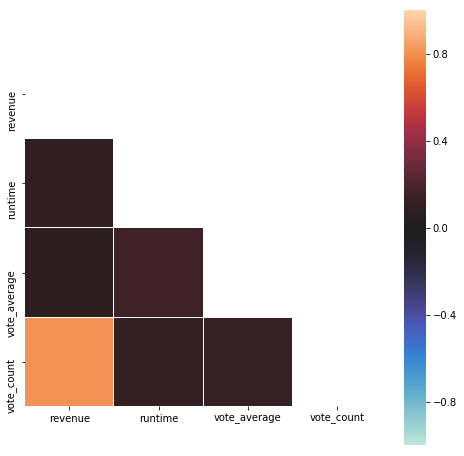

In [269]:
# A quick heatmap of movie_metadata. It seems revenue and the number of votes are correlated.
import seaborn as sns
corr = metadata_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=False, linewidths=0.2, center=0)

In [270]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
dataframes = (keywords_df, credits_df, metadata_df)
# Pandas DataFrames don't have name attributes.
df_names = ("keywords", "credits", "movies_metadata")
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
None

In [280]:
trial = keywords_df.join(credits_df)

In [281]:
trial.head(10)
# Keywords match up with cast/crew

,keywords,cast,crew
id,,,
2,"[{'id': 240, 'name': 'underdog'}, {'id': 378, ...","[{'cast_id': 3, 'character': 'Taisto Olavi Kas...","[{'credit_id': '52fe420dc3a36847f800001f', 'de..."
3,"[{'id': 1361, 'name': 'salesclerk'}, {'id': 17...","[{'cast_id': 5, 'character': 'Nikander', 'cred...","[{'credit_id': '52fe420dc3a36847f8000077', 'de..."
5,"[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...","[{'cast_id': 42, 'character': 'Ted the Bellhop...","[{'credit_id': '52fe420dc3a36847f800011b', 'de..."
6,"[{'id': 520, 'name': 'chicago'}, {'id': 2231, ...","[{'cast_id': 7, 'character': 'Frank Wyatt', 'c...","[{'credit_id': '52fe420dc3a36847f800023d', 'de..."
11,"[{'id': 803, 'name': 'android'}, {'id': 4270, ...","[{'cast_id': 3, 'character': 'Luke Skywalker',...","[{'credit_id': '52fe420dc3a36847f8000437', 'de..."
12,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 8, 'character': 'Marlin (voice)',...","[{'credit_id': '52fe420ec3a36847f80006b1', 'de..."
13,"[{'id': 422, 'name': 'vietnam veteran'}, {'id'...","[{'cast_id': 7, 'character': 'Forrest Gump', '...","[{'credit_id': '52fe420ec3a36847f800072d', 'de..."
14,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...","[{'cast_id': 6, 'character': 'Lester Burnham',...","[{'credit_id': '52fe420ec3a36847f80007c5', 'de..."
15,"[{'id': 736, 'name': 'journalist'}, {'id': 918...","[{'cast_id': 5, 'character': 'Charles Foster K...","[{'credit_id': '52fe420ec3a36847f8000885', 'de..."


In [284]:
# Things go bad here.
test = metadata_df.join(trial)